<a href="https://colab.research.google.com/github/RounabhSahu/ML_Proxxmed/blob/main/Machine_Learning_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import os
import io
import random
import nibabel
import numpy as np
from glob import glob
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

from nibabel import load
import matplotlib.pyplot as plt
from keras.utils import Sequence
from IPython.display import Image, display
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from ipywidgets import interact, interactive, fixed, interact_manual,FloatRangeSlider,FloatSlider
import ipywidgets as widgets

from google.colab import drive
from scipy.ndimage import zoom
drive.mount('/content/drive')

In [58]:
# Set your data path
data_path = '/content/drive/MyDrive/HYPODENSITY-DATA/'

['/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_NCCT.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg013/ProxmedImg013_NCCT.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg014/ProxmedImg014_NCCT.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg021/ProxmedImg021_NCCT.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg022/ProxmedImg022_NCCT.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg025/ProxmedImg025_NCCT.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg043/ProxmedImg043_NCCT.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg331/ProxmedImg331_NCCT.nii.gz']
['/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg006/ProxmedImg006_ROI.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg013/ProxmedImg013_ROI.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg014/ProxmedImg014_ROI.nii.gz', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg021/ProxmedImg021_ROI.nii.gz', '/cont

In [57]:
all_files = sorted(glob(os.path.join(data_path, '*')))
print(all_files)

['/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg006', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg013', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg014', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg021', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg022', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg025', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg043', '/content/drive/MyDrive/HYPODENSITY-DATA/ProxmedImg331']


In [23]:
# Function to read and preprocess a single case
def read_case(case_id, target_shape=(256, 256, 30)):
    ncct_path = os.path.join(data_path, case_id, f'{case_id}_NCCT.nii.gz')
    roi_path = os.path.join(data_path, case_id, f'{case_id}_ROI.nii.gz')

    # Load the NIfTI files
    ncct_img = nib.load(ncct_path).get_fdata()
    roi_img = nib.load(roi_path).get_fdata()

    # Resize images to a common shape
    ncct_img_resized = zoom(ncct_img, target_shape / np.array(ncct_img.shape), order=1)
    roi_img_resized = zoom(roi_img, target_shape / np.array(roi_img.shape), order=0)

    return ncct_img_resized, roi_img_resized

# Get a list of all case IDs
case_ids = [folder for folder in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, folder))]

# Create six datasets for each face
datasets = {face: [] for face in ['top', 'bottom', 'front', 'back', 'left', 'right']}
labels = {face: [] for face in ['top', 'bottom', 'front', 'back', 'left', 'right']}

# Iterate over each case
for case_id in case_ids:
    ncct_img, roi_img = read_case(case_id)

    # Extract slices from different views
    for axis, face in zip([0, 0, 1, 1, 2, 2], ['top', 'bottom', 'front', 'back', 'left', 'right']):
        for i in range(10):
            slice_index = int(i * ncct_img.shape[axis] / 10)
            if axis == 0:
                slice_img = ncct_img[slice_index, :, :]
                slice_label = roi_img[slice_index, :, :]
            elif axis == 1:
                slice_img = ncct_img[:, slice_index, :]
                slice_label = roi_img[:, slice_index, :]
            else:
                slice_img = ncct_img[:, :, slice_index]
                slice_label = roi_img[:, :, slice_index]

            # Resize slices to a common shape
            slice_img_resized = zoom(slice_img, (256 / slice_img.shape[0], 256 / slice_img.shape[1]), order=1)
            slice_label_resized = zoom(slice_label, (256 / slice_label.shape[0], 256 / slice_label.shape[1]), order=0)

            datasets[face].append(slice_img_resized)
            labels[face].append(slice_label_resized)

# Convert lists to numpy arrays for each face
datasets = {face: np.array(data, dtype=np.float32) for face, data in datasets.items()}
labels = {face: np.array(label, dtype=np.float32) for face, label in labels.items()}

# Print the shapes of the datasets for each face
for face in datasets.keys():
    print(f"{face.capitalize()} Dataset Shape:", datasets[face].shape)
    print(f"{face.capitalize()} Labels Shape:", labels[face].shape)

Top Dataset Shape: (80, 256, 256)
Top Labels Shape: (80, 256, 256)
Bottom Dataset Shape: (80, 256, 256)
Bottom Labels Shape: (80, 256, 256)
Front Dataset Shape: (80, 256, 256)
Front Labels Shape: (80, 256, 256)
Back Dataset Shape: (80, 256, 256)
Back Labels Shape: (80, 256, 256)
Left Dataset Shape: (80, 256, 256)
Left Labels Shape: (80, 256, 256)
Right Dataset Shape: (80, 256, 256)
Right Labels Shape: (80, 256, 256)


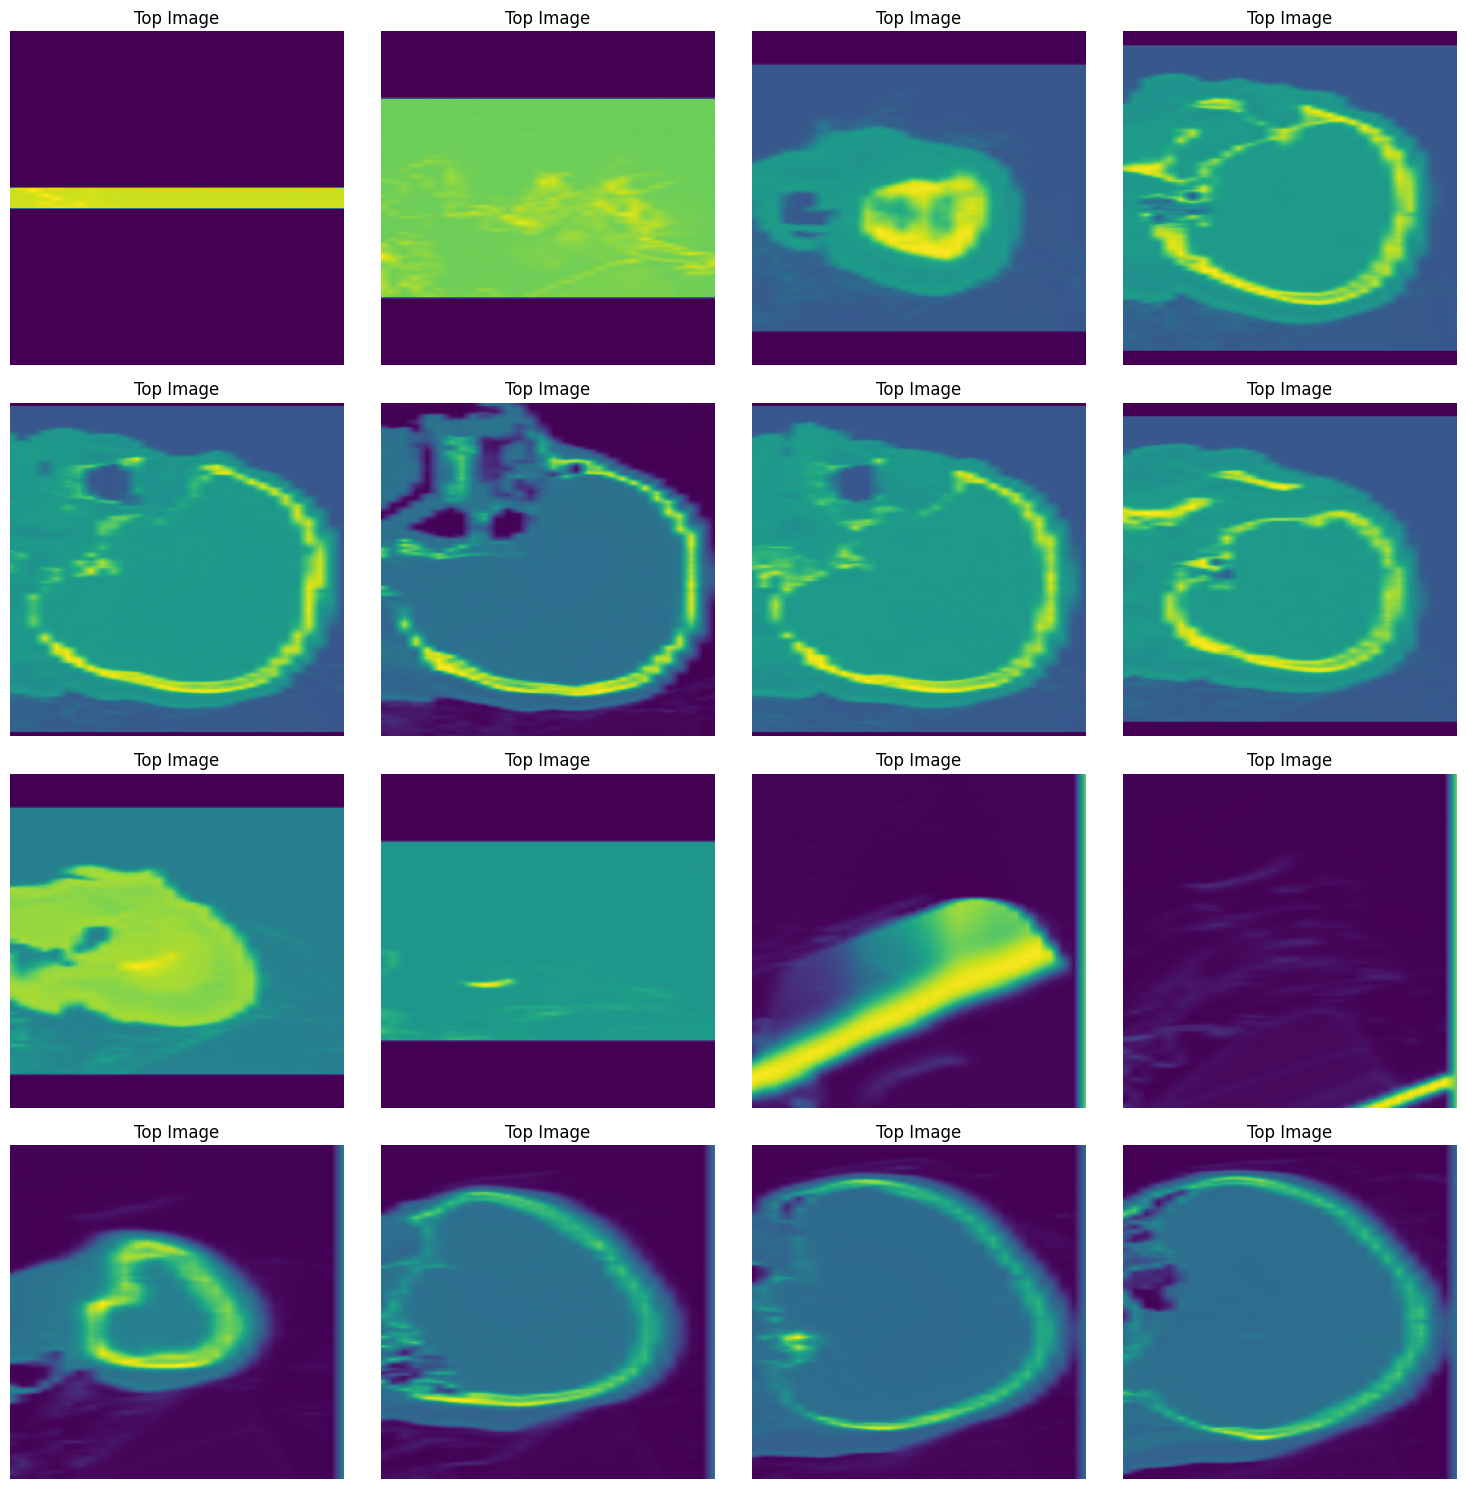

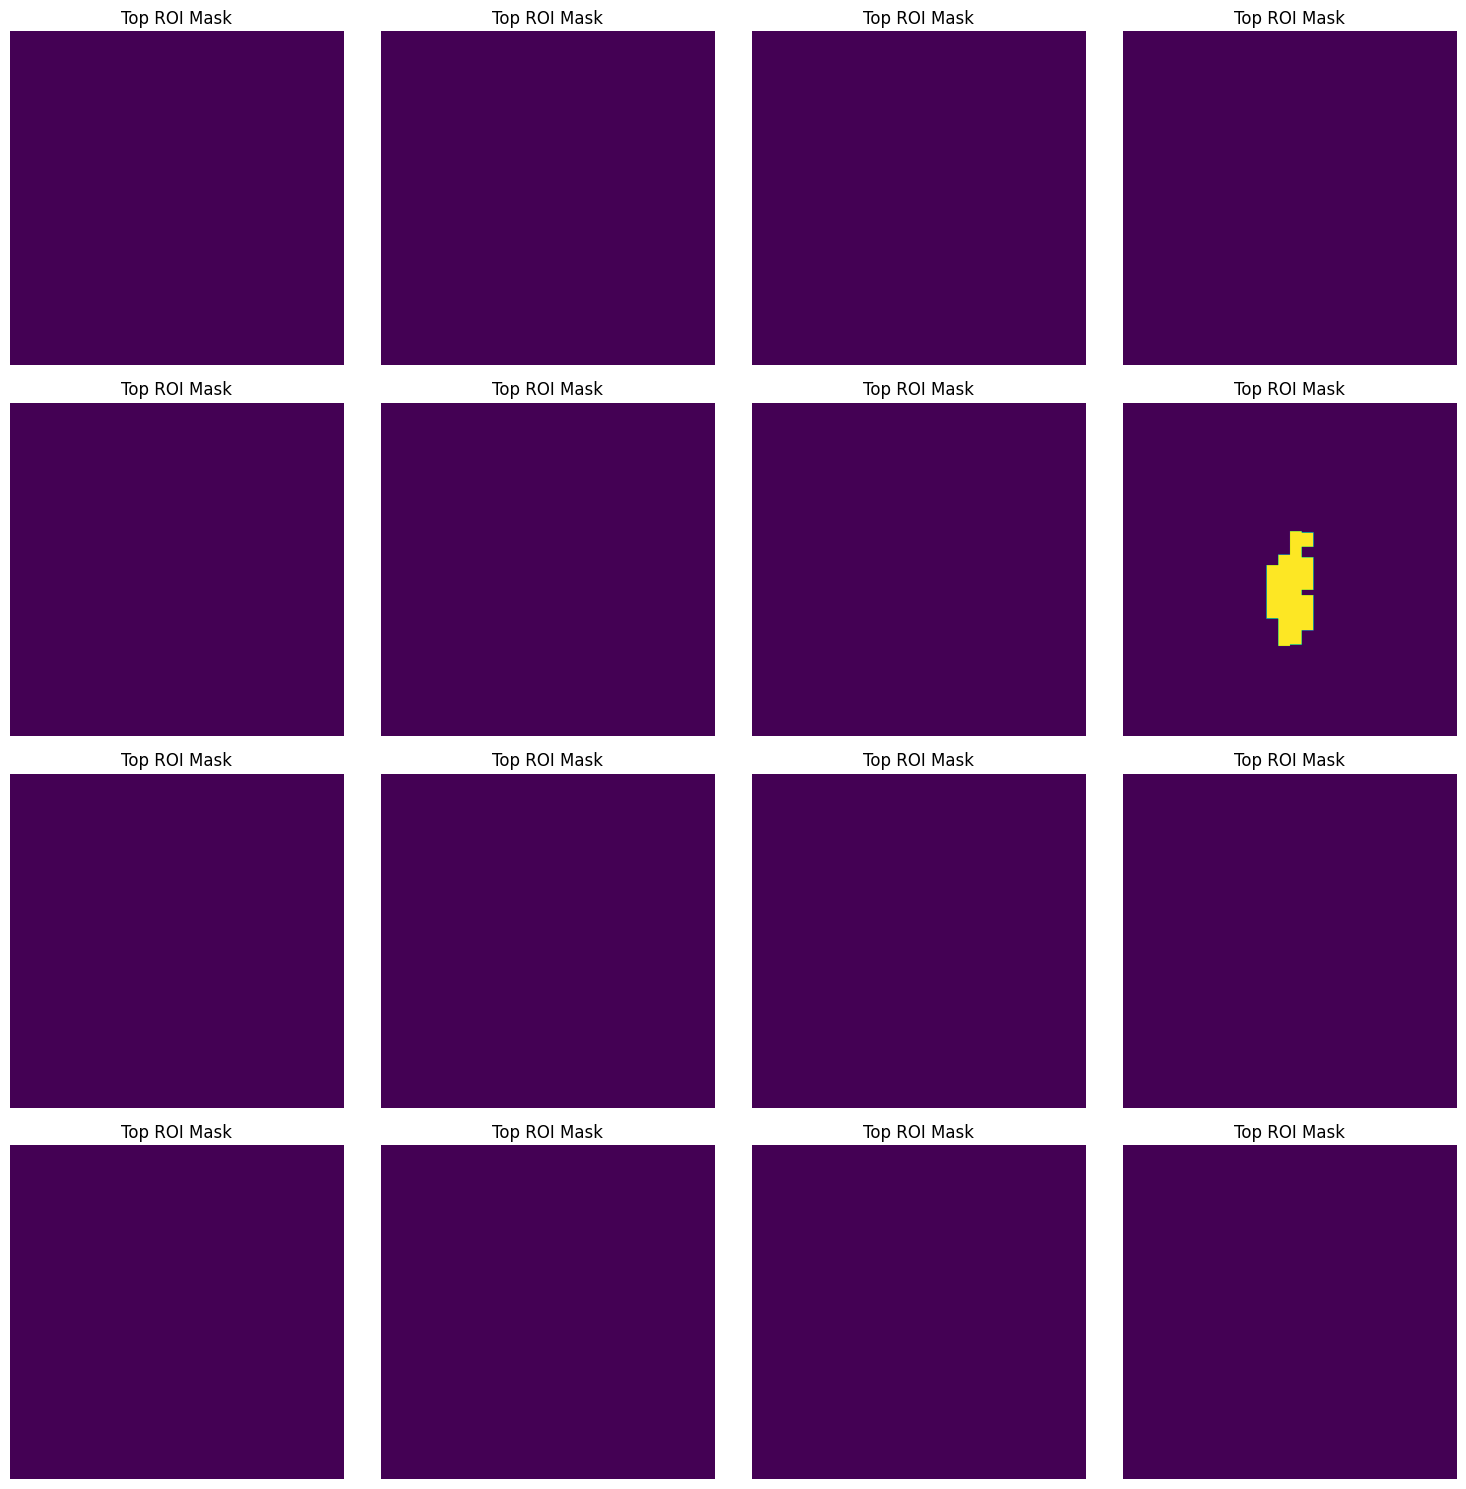

In [25]:
# Function to plot a grid of images
def plot_slices(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            axes[i, j].imshow(images[index], cmap='viridis')
            axes[i, j].set_title(titles[index])
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Define the number of rows and columns for the grid
rows = 4
cols = 4

# Choose the face to visualize ('top', 'bottom', 'front', 'back', 'left', 'right')
face_to_visualize = 'top'

# Extract a subset of the data for visualization (adjust as needed)
subset_data = datasets[face_to_visualize][:rows * cols]
subset_labels = labels[face_to_visualize][:rows * cols]

# Plot the grid of images for the chosen face
plot_slices(subset_data, titles=[f'{face_to_visualize.capitalize()} Image'] * len(subset_data), rows=rows, cols=cols)
plot_slices(subset_labels, titles=[f'{face_to_visualize.capitalize()} ROI Mask'] * len(subset_labels), rows=rows, cols=cols)

In [28]:
def visualize_image(image, label, threshold, window, level, slice_index, axis):
    # Apply thresholding
    image = np.where(image > threshold, image, 0)

    # Adjust window/level
    img_min = level - window / 2
    img_max = level + window / 2
    image = np.clip(image, img_min, img_max)

    # Select the slice along the specified axis
    if axis == 'Axial':
        selected_slice = image[:, :, slice_index]
    elif axis == 'Sagittal':
        selected_slice = image[:, slice_index, :]
    else:  # 'Coronal'
        selected_slice = image[slice_index, :, :]

    # Display the image and ROI mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(selected_slice, cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label[:, :, slice_index], cmap='viridis', alpha=0.7)
    plt.title('ROI Mask')
    plt.axis('off')

    plt.show()

# Load a sample image and label
sample_case_id = case_ids[0]
sample_image, sample_label = read_case(sample_case_id)

# Define interactive sliders
threshold_slider = widgets.FloatSlider(value=0, min=0, max=np.max(sample_image), step=1, description='Threshold:')
window_slider = widgets.FloatSlider(value=np.max(sample_image), min=1, max=np.max(sample_image), step=1, description='Window:')
level_slider = widgets.FloatSlider(value=np.max(sample_image) / 2, min=0, max=np.max(sample_image), step=1, description='Level:')
slice_slider = widgets.IntSlider(value=sample_image.shape[2] // 2, min=0, max=sample_image.shape[2] - 1, step=1, description='Slice:')
axis_dropdown = widgets.Dropdown(options=['Axial', 'Sagittal', 'Coronal'], value='Axial', description='View Axis:')

# Create the interactive interface
interactive_plot = interactive(
    visualize_image,
    image=fixed(sample_image),
    label=fixed(sample_label),
    threshold=threshold_slider,
    window=window_slider,
    level=level_slider,
    slice_index=slice_slider,
    axis=axis_dropdown
)

# Show the interactive plot
interactive_plot


interactive(children=(FloatSlider(value=0.0, description='Threshold:', max=2132.8773283485134, step=1.0), Floa…

In [42]:
# Load a sample image
sample_case_id = case_ids[1]
sample_image, sample_label = read_case(sample_case_id)

def plot_image_with_window_level_threshold(image, label, window_range, level, threshold):
    window_min, window_max = window_range
    img_min = level - (window_max - window_min) / 2
    img_max = level + (window_max - window_min) / 2
    image = np.clip(image, img_min, img_max)

    # Apply thresholding
    image = np.where(image > threshold, image, 0)

    plt.figure(figsize=(12, 6))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image[:, :, image.shape[2] // 2], cmap='gray')
    plt.title('Original Image')
    plt.colorbar()

    # Plot the ROI mask
    plt.subplot(1, 2, 2)
    plt.imshow(label[:, :, image.shape[2] // 2], cmap='gray')
    plt.title('ROI Mask')
    plt.colorbar()

    plt.show()

# Create interactive sliders
window_level_slider = FloatRangeSlider(
    # value=[0, np.max(sample_image)],
    value=[0, 75],
    min=0,
    max=np.max(sample_image),
    step=1,
    description='Window Range:'
)

threshold_slider = FloatSlider(
    # value=0,
    value=25,
    min=0,
    max=np.max(sample_image),
    step=1,
    description='Threshold:'
)

# Create the interactive interface
interactive_plot = interactive(
    plot_image_with_window_level_threshold,
    image=fixed(sample_image),
    label=fixed(sample_label),
    window_range=window_level_slider,
    # level=(0, np.max(sample_image), 1),
    level=(0, 10, 1),
    threshold=threshold_slider
)

# Show the interactive plot
interactive_plot


interactive(children=(FloatRangeSlider(value=(0.0, 75.0), description='Window Range:', max=2194.914563364221, …

In [65]:
class BrainHypoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, image_size):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.image_size = image_size
        self.length = int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1))
        y = np.zeros((self.batch_size, *self.image_size, 1))

        for i, (image_filename, mask_filename) in enumerate(zip(batch_x, batch_y)):
            image = nib.load(image_filename)
            mask = nib.load(mask_filename)
            # get the data from the image object
            image_data = image.get_fdata()
            mask_data = mask.get_fdata()
            # get random slice from the volumes
            slice_index = np.random.randint(0, image_data.shape[2] - 1)
            x[i, :, :, 0] = image_data[:, :, slice_index]
            y[i, :, :, 0] = (mask_data[:, :, slice_index] > 0).astype(np.float32)  # Assuming mask is binary

        return x, y

# Get the list of train images and masks
train_images = sorted(glob(os.path.join(data_path, '*', '*_NCCT.nii.gz')))
train_masks = sorted(glob(os.path.join(data_path, '*', '*_ROI.nii.gz')))

# Set batch size and image size
batch_size = 1
image_size = (512, 512)

# Create data generators
train_generator = BrainHypoDataGenerator(train_images[:10], train_masks[:10], batch_size, image_size)
val_generator = BrainHypoDataGenerator(train_images[10:], train_masks[10:], batch_size, image_size)

In [66]:
import tensorflow as tf

def encoder(inputs, filters, pool_size):
    conv_pool = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    conv_pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(conv_pool)
    return conv_pool

def decoder(inputs, concat_input, filters, transpose_size):
    up = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(filters, transpose_size, strides=(2, 2), padding='same')(inputs), concat_input])
    up = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(up)
    return up

def UNet(img_size=(512, 512, 1)):
    inputs = tf.keras.Input(img_size)
    print(inputs.shape)
    print()

    # Encoder
    conv_pool1 = encoder(inputs, 32, (2, 2))
    print("\t Enc. 1 ->", conv_pool1.shape)
    print()
    conv_pool2 = encoder(conv_pool1, 64, (2, 2))
    print("\t\t Enc. 2 ->", conv_pool2.shape)
    print()
    conv_pool3 = encoder(conv_pool2, 128, (2, 2))
    print("\t\t\t Enc. 3 ->", conv_pool3.shape)
    print()
    conv_pool4 = encoder(conv_pool3, 256, (2, 2))
    print("\t\t\t\t Enc. 4 ->", conv_pool4.shape)
    print()

    # Bottleneck
    bridge = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv_pool4)
    print("\t\t\t\t\t Bridge Conv ->", bridge.shape)
    print()

    # Decoder
    up6 = decoder(bridge, conv_pool3, 256, (2, 2))
    print("\t\t\t\t Dec. 4 ->", up6.shape)
    print()
    up7 = decoder(up6, conv_pool2, 128, (2, 2))
    print("\t\t\t Dec. 3 ->", up7.shape)
    print()
    up8 = decoder(up7, conv_pool1, 64, (2, 2))
    print("\t\t Dec. 2 ->", up8.shape)
    print()
    up9 = decoder(up8, inputs, 32, (2, 2))
    print("\t Dec. 1 ->", up9.shape)
    print()
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(up9)
    print(outputs.shape)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Set your input shape
input_shape = (512, 512, 1)

# Create the UNet model
model = UNet(img_size=input_shape)


(None, 512, 512, 1)

	 Enc. 1 -> (None, 256, 256, 32)

		 Enc. 2 -> (None, 128, 128, 64)

			 Enc. 3 -> (None, 64, 64, 128)

				 Enc. 4 -> (None, 32, 32, 256)

					 Bridge Conv -> (None, 32, 32, 512)

				 Dec. 4 -> (None, 64, 64, 256)

			 Dec. 3 -> (None, 128, 128, 128)

		 Dec. 2 -> (None, 256, 256, 64)

	 Dec. 1 -> (None, 512, 512, 32)

(None, 512, 512, 1)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

class BrainHypoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, image_size):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
      batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

      x = np.zeros((self.batch_size, *self.image_size))
      y = np.zeros((self.batch_size, *self.image_size, 1))

      for i, (image_filename, mask_filename) in enumerate(zip(batch_x, batch_y)):
          image = nib.load(image_filename)
          mask = nib.load(mask_filename)
          # get the data from the image object
          image_data = image.get_fdata()
          mask_data = mask.get_fdata()
          # get random slice from the volumes
          slice_index = np.random.randint(0, image_data.shape[2] - 1)
          # Add channel dimension to image_data
          x[i, :, :, 0] = image_data[:, :, slice_index]
          # Add channel dimension to mask_data
          y[i, :, :, 0] = np.expand_dims((mask_data[:, :, slice_index] > 0).astype(np.float32), axis=-1)

      return x, y

# Get the list of train, validation, and test images and masks
train_images = sorted(glob(os.path.join(data_path, '*', '*_NCCT.nii.gz')))
train_masks = sorted(glob(os.path.join(data_path, '*', '*_ROI.nii.gz')))
val_images = sorted(glob(os.path.join(data_path, '*', '*_NCCT.nii.gz')))
val_masks = sorted(glob(os.path.join(data_path, '*', '*_ROI.nii.gz')))
test_images = sorted(glob(os.path.join(data_path, '*', '*_NCCT.nii.gz')))
test_masks = sorted(glob(os.path.join(data_path, '*', '*_ROI.nii.gz')))

# Set batch size and image size
batch_size = 1
image_size = (512, 512, 1)  # Adjusted to 3D input

# Create data generators
train_generator = BrainHypoDataGenerator(train_images, train_masks, batch_size, image_size)
val_generator = BrainHypoDataGenerator(val_images, val_masks, batch_size, image_size)
test_generator = BrainHypoDataGenerator(test_images, test_masks, batch_size, image_size)

# Build the model
def UNet(img_size=(512, 512, 1)):
    inputs = tf.keras.Input(img_size)
    print(inputs.shape)
    print()

    # Encoder
    conv_pool1 = encoder(inputs, 32, (2, 2))
    print("\t Enc. 1 ->", conv_pool1.shape)
    print()
    conv_pool2 = encoder(conv_pool1, 64, (2, 2))
    print("\t\t Enc. 2 ->", conv_pool2.shape)
    print()
    conv_pool3 = encoder(conv_pool2, 128, (2, 2))
    print("\t\t\t Enc. 3 ->", conv_pool3.shape)
    print()
    conv_pool4 = encoder(conv_pool3, 256, (2, 2))
    print("\t\t\t\t Enc. 4 ->", conv_pool4.shape)
    print()

    # Bottleneck
    bridge = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv_pool4)
    print("\t\t\t\t\t Bridge Conv ->", bridge.shape)
    print()

    # Decoder
    up6 = decoder(bridge, conv_pool3, 256, (2, 2))
    print("\t\t\t\t Dec. 4 ->", up6.shape)
    print()
    up7 = decoder(up6, conv_pool2, 128, (2, 2))
    print("\t\t\t Dec. 3 ->", up7.shape)
    print()
    up8 = decoder(up7, conv_pool1, 64, (2, 2))
    print("\t\t Dec. 2 ->", up8.shape)
    print()
    up9 = decoder(up8, inputs, 32, (2, 2))
    print("\t Dec. 1 ->", up9.shape)
    print()
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(up9)
    print(outputs.shape)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create UNet model
model = UNet(img_size=image_size)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=[dice_coef])

# Set up model checkpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=200,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[checkpoint])

(None, 512, 512, 1)

	 Enc. 1 -> (None, 256, 256, 32)

		 Enc. 2 -> (None, 128, 128, 64)

			 Enc. 3 -> (None, 64, 64, 128)

				 Enc. 4 -> (None, 32, 32, 256)

					 Bridge Conv -> (None, 32, 32, 512)

				 Dec. 4 -> (None, 64, 64, 256)

			 Dec. 3 -> (None, 128, 128, 128)

		 Dec. 2 -> (None, 256, 256, 64)

	 Dec. 1 -> (None, 512, 512, 32)

(None, 512, 512, 1)
Epoch 1/200
8/8 [==============================] - 52s 6s/step - loss: 19.5256 - dice_coef: 0.4689 - val_loss: 25.0118 - val_dice_coef: 0.6251
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 5.5991 - dice_coef: 0.5051

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 59s 8s/step - loss: 5.5991 - dice_coef: 0.5051 - val_loss: 0.2651 - val_dice_coef: 0.0796
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.2836 - dice_coef: 0.0149

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 49s 6s/step - loss: 0.2836 - dice_coef: 0.0149 - val_loss: 0.0986 - val_dice_coef: 0.0085
Epoch 4/200
8/8 [==============================] - 72s 9s/step - loss: 0.0028 - dice_coef: 0.0057 - val_loss: 0.1975 - val_dice_coef: 0.0219
Epoch 5/200
8/8 [==============================] - 50s 6s/step - loss: 0.1189 - dice_coef: 0.1378 - val_loss: 0.0891 - val_dice_coef: 0.0745


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 6/200
8/8 [==============================] - 49s 6s/step - loss: 0.0790 - dice_coef: 0.0349 - val_loss: 0.0096 - val_dice_coef: 0.1327


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7/200
8/8 [==============================] - 63s 8s/step - loss: 0.0853 - dice_coef: 0.0228 - val_loss: 0.0751 - val_dice_coef: 0.0764
Epoch 8/200
8/8 [==============================] - 49s 6s/step - loss: 0.0756 - dice_coef: 0.0173 - val_loss: 0.0171 - val_dice_coef: 0.2825
Epoch 9/200
8/8 [==============================] - 57s 8s/step - loss: 0.0192 - dice_coef: 0.2725 - val_loss: 0.0301 - val_dice_coef: 0.0563
Epoch 10/200
8/8 [==============================] - 49s 6s/step - loss: 0.0955 - dice_coef: 0.0164 - val_loss: 0.0759 - val_dice_coef: 0.0309
Epoch 11/200
8/8 [==============================] - 61s 8s/step - loss: 0.0469 - dice_coef: 0.0996 - val_loss: 0.0284 - val_dice_coef: 0.0193
Epoch 12/200
8/8 [==============================] - 49s 6s/step - loss: 0.0518 - dice_coef: 0.0438 - val_loss: 0.0590 - val_dice_coef: 0.0374
Epoch 13/200
8/8 [==============================] - 46s 6s/step - loss: 0.0405 - dice_coef: 0.1846 - val_loss: 0.0352 - val_dice_coef: 0.0909
Epoch 14/

In [69]:


print(train_images[:10])  # Print the first 10 training image paths
print(train_masks[:10])   # Print the first 10 training mask paths

[]
[]
